In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                     #transforms.Resize((28, 28)),
                                     transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                     #transforms.RandomRotation((-7.0, 7.0)),
                                     #transforms.RandomGrayscale(p=0.01),        
                                     #transforms.ColorJitter(brightness=0.2, contrast=0.2),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.1307,), (0.3081,))
                                       # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

/home/rogbot/deepvision/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=16, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [5]:
import torch.nn.functional as F
dropout_value = 0.01

class NetLN(nn.Module):
    def __init__(self):
        super(NetLN, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=11, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.LayerNorm([11, 26, 26]),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=11, out_channels=19, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.LayerNorm([19, 24, 24]),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=19, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            #nn.BatchNorm2d(10),
            nn.LayerNorm([10, 24, 24]),

        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.LayerNorm([15, 10, 10]),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.LayerNorm([15, 8, 8]),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.LayerNorm([15, 6, 6]),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.LayerNorm([15, 6, 6]),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

       
        self.fc = nn.Sequential(
            nn.Linear(15, 10,bias=False),
            nn.BatchNorm1d(10),
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)   
        
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return F.log_softmax(x, dim=-1)

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
modelLN = NetLN().to(device)
summary(modelLN, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 11, 26, 26]              99
              ReLU-2           [-1, 11, 26, 26]               0
         LayerNorm-3           [-1, 11, 26, 26]          14,872
           Dropout-4           [-1, 11, 26, 26]               0
            Conv2d-5           [-1, 19, 24, 24]           1,881
              ReLU-6           [-1, 19, 24, 24]               0
         LayerNorm-7           [-1, 19, 24, 24]          21,888
           Dropout-8           [-1, 19, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             190
        LayerNorm-10           [-1, 10, 24, 24]          11,520
        MaxPool2d-11           [-1, 10, 12, 12]               0
           Conv2d-12           [-1, 15, 10, 10]           1,350
             ReLU-13           [-1, 15, 10, 10]               0
        LayerNorm-14           [-1

In [7]:
import torch.nn.functional as F
dropout_value = 0.01

class NetGN(nn.Module):
    def __init__(self):
        super(NetGN, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=11, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(11),
            nn.GroupNorm(1, 11),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=11, out_channels=19, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(19),
            nn.GroupNorm(1, 19),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=19, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            #nn.BatchNorm2d(10),
            nn.GroupNorm(5, 10),

        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            #nn.BatchNorm2d(15),
            nn.GroupNorm(5, 15),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            #nn.BatchNorm2d(15),
            nn.GroupNorm(5, 15),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            #nn.BatchNorm2d(15),
            nn.GroupNorm(5, 15),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            #nn.BatchNorm2d(15),
            nn.GroupNorm(5, 15),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

       
        self.fc = nn.Sequential(
            nn.Linear(15, 10,bias=False),
            nn.BatchNorm1d(10),
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)   
        
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return F.log_softmax(x, dim=-1)

In [8]:
modelGN = NetGN().to(device)
summary(modelGN, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 11, 26, 26]              99
              ReLU-2           [-1, 11, 26, 26]               0
         GroupNorm-3           [-1, 11, 26, 26]              22
           Dropout-4           [-1, 11, 26, 26]               0
            Conv2d-5           [-1, 19, 24, 24]           1,881
              ReLU-6           [-1, 19, 24, 24]               0
         GroupNorm-7           [-1, 19, 24, 24]              38
           Dropout-8           [-1, 19, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             190
        GroupNorm-10           [-1, 10, 24, 24]              20
        MaxPool2d-11           [-1, 10, 12, 12]               0
           Conv2d-12           [-1, 15, 10, 10]           1,350
             ReLU-13           [-1, 15, 10, 10]               0
        GroupNorm-14           [-1, 15,

In [9]:
import torch.nn.functional as F
dropout_value = 0.01

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=11, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(11),
            #nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=11, out_channels=19, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(19),
            #nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=19, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),

        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1
       
        self.fc = nn.Sequential(
            nn.Linear(15, 10,bias=False),
            nn.BatchNorm1d(10),
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)   
        
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return F.log_softmax(x, dim=-1)

In [10]:
modelBNL1 = Net().to(device)
summary(modelBNL1, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 11, 26, 26]              99
              ReLU-2           [-1, 11, 26, 26]               0
       BatchNorm2d-3           [-1, 11, 26, 26]              22
            Conv2d-4           [-1, 19, 24, 24]           1,881
              ReLU-5           [-1, 19, 24, 24]               0
       BatchNorm2d-6           [-1, 19, 24, 24]              38
            Conv2d-7           [-1, 10, 24, 24]             190
       BatchNorm2d-8           [-1, 10, 24, 24]              20
         MaxPool2d-9           [-1, 10, 12, 12]               0
           Conv2d-10           [-1, 15, 10, 10]           1,350
             ReLU-11           [-1, 15, 10, 10]               0
      BatchNorm2d-12           [-1, 15, 10, 10]              30
          Dropout-13           [-1, 15, 10, 10]               0
           Conv2d-14             [-1, 1

In [11]:
from tqdm import tqdm

train_lossesLN = []
test_lossesLN = []
train_accLN = []
test_accLN = []

def trainLN(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_lossesLN.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_accLN.append(100*correct/processed)

def testLN(model, device, test_loader):
    model.eval()
    test_lossLN = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_lossLN += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_lossLN /= len(test_loader.dataset)
    test_lossesLN.append(test_lossLN)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_lossLN, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    
    test_accLN.append(100. * correct / len(test_loader.dataset))

In [12]:
train_lossesGN = []
test_lossesGN = []
train_accGN = []
test_accGN = []

def trainGN(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_lossesGN.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_accGN.append(100*correct/processed)

def testGN(model, device, test_loader):
    model.eval()
    test_lossGN = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_lossGN += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_lossGN /= len(test_loader.dataset)
    test_lossesGN.append(test_lossGN)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_lossGN, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    
    test_accGN.append(100. * correct / len(test_loader.dataset))

In [13]:
from tqdm import tqdm
from torch.autograd import Variable

train_lossesBNL1 = []
test_lossesBNL1 = []
train_accBNL1 = []
test_accBNL1 = []

lambda_ = 0.0005

def trainBNL1(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    
    # L1 regularization  
    #L1_norm = Variable( torch.FloatTensor(1), requires_grad=True)
    #L1_norm = sum(w.abs().sum() for w in model.parameters())
    #loss += lambda_ * L1_norm
    
    l1_reg = None
    for w in model.parameters():
        if l1_reg is None:
            l1_reg = w.abs().sum()
        else:
            l1_reg = l1_reg + w.abs().sum()
            
    loss += lambda_*l1_reg
   
    train_lossesBNL1.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_accBNL1.append(100*correct/processed)

def testBNL1(model, device, test_loader):
    model.eval()
    test_lossBNL1 = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_lossBNL1 += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_lossBNL1 /= len(test_loader.dataset)
    test_lossesBNL1.append(test_lossBNL1)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_lossBNL1, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    
    test_accBNL1.append(100. * correct / len(test_loader.dataset))

In [14]:
from torch.optim.lr_scheduler import StepLR

modelLN =  NetLN().to(device)
modelGN =  NetGN().to(device)
modelBNL1 = Net().to(device)

optimizerLN = optim.SGD(modelLN.parameters(), lr=0.01, momentum=0.9)
optimizerGN = optim.SGD(modelGN.parameters(), lr=0.01, momentum=0.9)
optimizerBNL1 = optim.SGD(modelBNL1.parameters(), lr=0.01, momentum=0.9)


#schedulerLN = StepLR(optimizerLN, step_size=6, gamma=0.00001)
#schedulerGN = StepLR(optimizerGN, step_size=6, gamma=0.00001)
#schedulerBNL1 = StepLR(optimizerBNL1, step_size=6, gamma=0.00001)


#learning_rate = 0.01
#optimizerLN = torch.optim.Adam(modelLN.parameters(), lr=learning_rate)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.0001)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    trainLN(modelLN, device, train_loader, optimizerLN, epoch)
    trainGN(modelGN, device, train_loader, optimizerGN, epoch)
    trainBNL1(modelBNL1, device, train_loader, optimizerBNL1, epoch)
    
    #schedulerLN.step()
    #schedulerGN.step()
    #schedulerBNL1.step()

    testLN(modelLN, device, test_loader)
    testGN(modelGN, device, test_loader)
    testBNL1(modelBNL1, device, test_loader)

EPOCH: 0


Loss=0.18163728713989258 Batch_id=937 Accuracy=94.16: 100%|█| 938/938 [00:09<00:
Loss=0.030739421024918556 Batch_id=937 Accuracy=94.53: 100%|█| 938/938 [00:09<00
Loss=0.3241875171661377 Batch_id=937 Accuracy=95.49: 100%|█| 938/938 [00:11<00:0



Test set: Average loss: 0.0808, Accuracy: 9786/10000 (97.86%)


Test set: Average loss: 0.0744, Accuracy: 9813/10000 (98.13%)


Test set: Average loss: 0.1132, Accuracy: 9719/10000 (97.19%)

EPOCH: 1


Loss=0.11654933542013168 Batch_id=937 Accuracy=97.46: 100%|█| 938/938 [00:09<00:
Loss=0.11195391416549683 Batch_id=937 Accuracy=97.71: 100%|█| 938/938 [00:09<00:
Loss=0.2320193499326706 Batch_id=937 Accuracy=97.49: 100%|█| 938/938 [00:12<00:0



Test set: Average loss: 0.0640, Accuracy: 9829/10000 (98.29%)


Test set: Average loss: 0.0448, Accuracy: 9877/10000 (98.77%)


Test set: Average loss: 0.0596, Accuracy: 9832/10000 (98.32%)

EPOCH: 2


Loss=0.0281678456813097 Batch_id=937 Accuracy=98.06: 100%|█| 938/938 [00:11<00:0
Loss=0.02552105113863945 Batch_id=937 Accuracy=98.22: 100%|█| 938/938 [00:11<00:
Loss=0.20403914153575897 Batch_id=937 Accuracy=97.57: 100%|█| 938/938 [00:13<00:



Test set: Average loss: 0.0406, Accuracy: 9892/10000 (98.92%)


Test set: Average loss: 0.0345, Accuracy: 9899/10000 (98.99%)


Test set: Average loss: 0.0473, Accuracy: 9865/10000 (98.65%)

EPOCH: 3


Loss=0.29251864552497864 Batch_id=937 Accuracy=98.36: 100%|█| 938/938 [00:11<00:
Loss=0.03040672279894352 Batch_id=937 Accuracy=98.44: 100%|█| 938/938 [00:12<00:
Loss=0.2299375832080841 Batch_id=937 Accuracy=97.71: 100%|█| 938/938 [00:13<00:0



Test set: Average loss: 0.0309, Accuracy: 9907/10000 (99.07%)


Test set: Average loss: 0.0346, Accuracy: 9902/10000 (99.02%)


Test set: Average loss: 0.0698, Accuracy: 9809/10000 (98.09%)

EPOCH: 4


Loss=0.16467441618442535 Batch_id=937 Accuracy=98.44: 100%|█| 938/938 [00:11<00:
Loss=0.011026114225387573 Batch_id=937 Accuracy=98.60: 100%|█| 938/938 [00:12<00
Loss=0.5520038604736328 Batch_id=937 Accuracy=97.68: 100%|█| 938/938 [00:14<00:0



Test set: Average loss: 0.0359, Accuracy: 9894/10000 (98.94%)


Test set: Average loss: 0.0277, Accuracy: 9922/10000 (99.22%)


Test set: Average loss: 0.0494, Accuracy: 9858/10000 (98.58%)

EPOCH: 5


Loss=0.05443902686238289 Batch_id=937 Accuracy=98.68: 100%|█| 938/938 [00:12<00:
Loss=0.1611819863319397 Batch_id=937 Accuracy=98.61: 100%|█| 938/938 [00:11<00:0
Loss=0.20503497123718262 Batch_id=937 Accuracy=97.80: 100%|█| 938/938 [00:13<00:



Test set: Average loss: 0.0301, Accuracy: 9904/10000 (99.04%)


Test set: Average loss: 0.0236, Accuracy: 9933/10000 (99.33%)


Test set: Average loss: 0.0316, Accuracy: 9911/10000 (99.11%)

EPOCH: 6


Loss=0.05799667909741402 Batch_id=937 Accuracy=98.76: 100%|█| 938/938 [00:10<00:
Loss=0.06715572625398636 Batch_id=937 Accuracy=98.81: 100%|█| 938/938 [00:11<00:
Loss=0.35717687010765076 Batch_id=937 Accuracy=97.81: 100%|█| 938/938 [00:13<00:



Test set: Average loss: 0.0309, Accuracy: 9910/10000 (99.10%)


Test set: Average loss: 0.0266, Accuracy: 9922/10000 (99.22%)


Test set: Average loss: 0.0551, Accuracy: 9840/10000 (98.40%)

EPOCH: 7


Loss=0.012605004012584686 Batch_id=937 Accuracy=98.80: 100%|█| 938/938 [00:11<00
Loss=0.00834488496184349 Batch_id=937 Accuracy=98.85: 100%|█| 938/938 [00:11<00:
Loss=0.3049098253250122 Batch_id=937 Accuracy=97.79: 100%|█| 938/938 [00:13<00:0



Test set: Average loss: 0.0269, Accuracy: 9921/10000 (99.21%)


Test set: Average loss: 0.0217, Accuracy: 9939/10000 (99.39%)


Test set: Average loss: 0.0532, Accuracy: 9846/10000 (98.46%)

EPOCH: 8


Loss=0.0073173814453184605 Batch_id=937 Accuracy=98.85: 100%|█| 938/938 [00:10<0
Loss=0.014510496519505978 Batch_id=937 Accuracy=98.93: 100%|█| 938/938 [00:11<00
Loss=0.3636515736579895 Batch_id=937 Accuracy=97.84: 100%|█| 938/938 [00:13<00:0



Test set: Average loss: 0.0215, Accuracy: 9935/10000 (99.35%)


Test set: Average loss: 0.0269, Accuracy: 9927/10000 (99.27%)


Test set: Average loss: 0.0392, Accuracy: 9888/10000 (98.88%)

EPOCH: 9


Loss=0.01794734224677086 Batch_id=937 Accuracy=98.97: 100%|█| 938/938 [00:12<00:
Loss=0.005895727779716253 Batch_id=937 Accuracy=98.99: 100%|█| 938/938 [00:13<00
Loss=0.195712149143219 Batch_id=937 Accuracy=97.85: 100%|█| 938/938 [00:15<00:00



Test set: Average loss: 0.0221, Accuracy: 9938/10000 (99.38%)


Test set: Average loss: 0.0206, Accuracy: 9936/10000 (99.36%)


Test set: Average loss: 0.0397, Accuracy: 9886/10000 (98.86%)

EPOCH: 10


Loss=0.008439493365585804 Batch_id=937 Accuracy=99.03: 100%|█| 938/938 [00:12<00
Loss=0.02303198166191578 Batch_id=937 Accuracy=99.06: 100%|█| 938/938 [00:11<00:
Loss=0.19508467614650726 Batch_id=937 Accuracy=97.90: 100%|█| 938/938 [00:14<00:



Test set: Average loss: 0.0223, Accuracy: 9937/10000 (99.37%)


Test set: Average loss: 0.0246, Accuracy: 9929/10000 (99.29%)


Test set: Average loss: 0.0369, Accuracy: 9897/10000 (98.97%)

EPOCH: 11


Loss=0.013723596930503845 Batch_id=937 Accuracy=99.05: 100%|█| 938/938 [00:12<00
Loss=0.04221523180603981 Batch_id=937 Accuracy=99.10: 100%|█| 938/938 [00:12<00:
Loss=0.3883270025253296 Batch_id=937 Accuracy=97.94: 100%|█| 938/938 [00:14<00:0



Test set: Average loss: 0.0213, Accuracy: 9939/10000 (99.39%)


Test set: Average loss: 0.0201, Accuracy: 9940/10000 (99.40%)


Test set: Average loss: 0.0608, Accuracy: 9813/10000 (98.13%)

EPOCH: 12


Loss=0.055758360773324966 Batch_id=937 Accuracy=99.17: 100%|█| 938/938 [00:12<00
Loss=0.03116372600197792 Batch_id=937 Accuracy=99.06: 100%|█| 938/938 [00:12<00:
Loss=0.16160689294338226 Batch_id=937 Accuracy=97.79: 100%|█| 938/938 [00:15<00:



Test set: Average loss: 0.0224, Accuracy: 9933/10000 (99.33%)


Test set: Average loss: 0.0238, Accuracy: 9927/10000 (99.27%)


Test set: Average loss: 0.0486, Accuracy: 9856/10000 (98.56%)

EPOCH: 13


Loss=0.07928912341594696 Batch_id=937 Accuracy=99.25: 100%|█| 938/938 [00:12<00:
Loss=0.0369512140750885 Batch_id=937 Accuracy=99.17: 100%|█| 938/938 [00:11<00:0
Loss=0.23284366726875305 Batch_id=937 Accuracy=97.91: 100%|█| 938/938 [00:13<00:



Test set: Average loss: 0.0248, Accuracy: 9925/10000 (99.25%)


Test set: Average loss: 0.0200, Accuracy: 9944/10000 (99.44%)


Test set: Average loss: 0.0431, Accuracy: 9865/10000 (98.65%)

EPOCH: 14


Loss=0.009030185639858246 Batch_id=937 Accuracy=99.20: 100%|█| 938/938 [00:11<00
Loss=0.016375096514821053 Batch_id=937 Accuracy=99.21: 100%|█| 938/938 [00:11<00
Loss=0.5775324106216431 Batch_id=937 Accuracy=97.90: 100%|█| 938/938 [00:14<00:0



Test set: Average loss: 0.0230, Accuracy: 9934/10000 (99.34%)


Test set: Average loss: 0.0262, Accuracy: 9922/10000 (99.22%)


Test set: Average loss: 0.0637, Accuracy: 9814/10000 (98.14%)

EPOCH: 15


Loss=0.0057960739359259605 Batch_id=937 Accuracy=99.22: 100%|█| 938/938 [00:11<0
Loss=0.01026278268545866 Batch_id=937 Accuracy=99.24: 100%|█| 938/938 [00:12<00:
Loss=0.2526845633983612 Batch_id=937 Accuracy=97.79: 100%|█| 938/938 [00:14<00:0



Test set: Average loss: 0.0233, Accuracy: 9929/10000 (99.29%)


Test set: Average loss: 0.0229, Accuracy: 9942/10000 (99.42%)


Test set: Average loss: 0.0491, Accuracy: 9848/10000 (98.48%)

EPOCH: 16


Loss=0.04985710605978966 Batch_id=937 Accuracy=99.27: 100%|█| 938/938 [00:11<00:
Loss=0.004136756528168917 Batch_id=937 Accuracy=99.24: 100%|█| 938/938 [00:11<00
Loss=0.15607614815235138 Batch_id=937 Accuracy=97.88: 100%|█| 938/938 [00:14<00:



Test set: Average loss: 0.0219, Accuracy: 9943/10000 (99.43%)


Test set: Average loss: 0.0212, Accuracy: 9937/10000 (99.37%)


Test set: Average loss: 0.0448, Accuracy: 9868/10000 (98.68%)

EPOCH: 17


Loss=0.0041382466442883015 Batch_id=937 Accuracy=99.33: 100%|█| 938/938 [00:11<0
Loss=0.012609356082975864 Batch_id=937 Accuracy=99.24: 100%|█| 938/938 [00:11<00
Loss=0.167902410030365 Batch_id=937 Accuracy=97.89: 100%|█| 938/938 [00:13<00:00



Test set: Average loss: 0.0183, Accuracy: 9943/10000 (99.43%)


Test set: Average loss: 0.0201, Accuracy: 9931/10000 (99.31%)


Test set: Average loss: 0.0517, Accuracy: 9837/10000 (98.37%)

EPOCH: 18


Loss=0.08973267674446106 Batch_id=937 Accuracy=99.30: 100%|█| 938/938 [00:11<00:
Loss=0.045914966613054276 Batch_id=937 Accuracy=99.33: 100%|█| 938/938 [00:11<00
Loss=0.2899554371833801 Batch_id=937 Accuracy=97.98: 100%|█| 938/938 [00:13<00:0



Test set: Average loss: 0.0225, Accuracy: 9934/10000 (99.34%)


Test set: Average loss: 0.0225, Accuracy: 9927/10000 (99.27%)


Test set: Average loss: 0.0413, Accuracy: 9879/10000 (98.79%)

EPOCH: 19


Loss=0.015332196839153767 Batch_id=937 Accuracy=99.28: 100%|█| 938/938 [00:11<00
Loss=0.022884443402290344 Batch_id=937 Accuracy=99.36: 100%|█| 938/938 [00:11<00
Loss=0.35976845026016235 Batch_id=937 Accuracy=97.84: 100%|█| 938/938 [00:13<00:



Test set: Average loss: 0.0206, Accuracy: 9945/10000 (99.45%)


Test set: Average loss: 0.0194, Accuracy: 9947/10000 (99.47%)


Test set: Average loss: 0.0442, Accuracy: 9867/10000 (98.67%)



<Figure size 432x288 with 0 Axes>

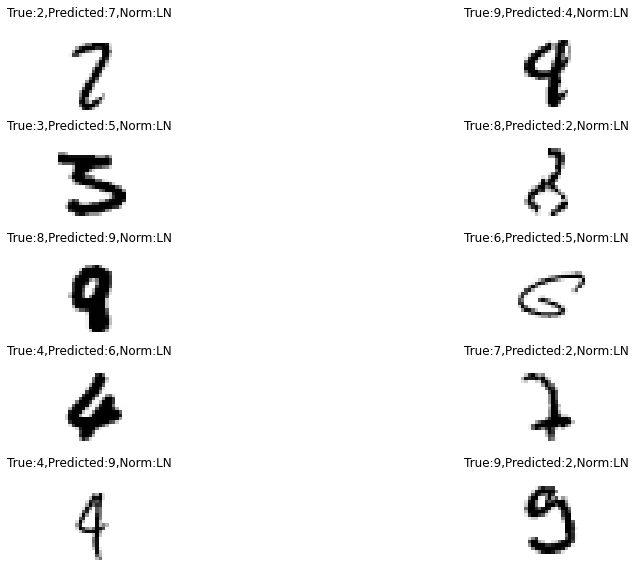

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

# load test data with batch size = 1 for predicting on CPU 
dataloader_args_ = dict(shuffle=False, batch_size=1)
test_ = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)
test_loader_ = torch.utils.data.DataLoader(test_, **dataloader_args_)

test_inf = datasets.MNIST('./data', train=False, download=True)

# keep model to CPU
device = torch.device("cpu")
modelLN =  modelLN.to(device)
modelLN.eval()

mismatch_label_predicted = []
mismatch_images = []
mismatch_tgt = []
mismatch_index = []

index = 0
with torch.no_grad():
    for data_, target_ in test_loader_:
        output_ = modelLN(data_)
        pred = output_.argmax(dim=1, keepdim=True)

        if pred != target_ :
            image,label  = test_inf[index]
            mismatch_images.append(image)
            mismatch_label_predicted.append(pred.item())
            mismatch_tgt.append(target_)
            mismatch_index.append(index)
              
        if len(mismatch_index) == 10:
            break
            
        index += 1  
  

index = 0
figure = plt.figure()
plt.figure(figsize=(15,10))
num_of_images = 10
for index in range(1, num_of_images + 1):
    plt.subplot(5, 2, index)
    plt.axis('off')
    plt.gca().set_title('True:{0},Predicted:{1},Norm:LN '.format(mismatch_tgt[index-1].item(), mismatch_label_predicted[index-1]))
    plt.imshow(mismatch_images[index-1], cmap='gray_r')

plt.savefig('LN10missmatch.jpg', bbox_inches='tight')


<Figure size 432x288 with 0 Axes>

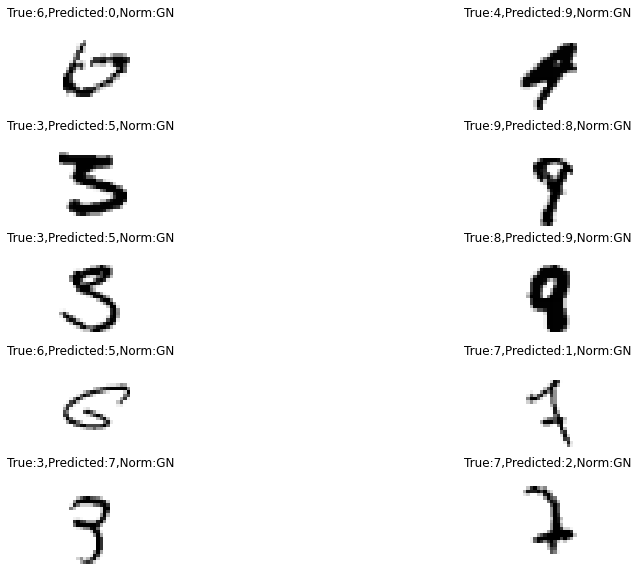

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

# load test data with batch size = 1 for predicting on CPU 
dataloader_args_ = dict(shuffle=False, batch_size=1)
test_ = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)
test_loader_ = torch.utils.data.DataLoader(test_, **dataloader_args_)

test_inf = datasets.MNIST('./data', train=False, download=True)

# keep model to CPU
device = torch.device("cpu")
modelGN =  modelGN.to(device)
modelGN.eval()

mismatch_label_predicted = []
mismatch_images = []
mismatch_tgt = []
mismatch_index = []

index = 0
with torch.no_grad():
    for data_, target_ in test_loader_:
        output_ = modelGN(data_)
        pred = output_.argmax(dim=1, keepdim=True)

        if pred != target_ :
            image,label  = test_inf[index]
            mismatch_images.append(image)
            mismatch_label_predicted.append(pred.item())
            mismatch_tgt.append(target_)
            mismatch_index.append(index)
              
        if len(mismatch_index) == 10:
            break
            
        index += 1  
  

index = 0
figure = plt.figure()
plt.figure(figsize=(15,10))
num_of_images = 10
for index in range(1, num_of_images + 1):
    plt.subplot(5, 2, index)
    plt.axis('off')
    plt.gca().set_title('True:{0},Predicted:{1},Norm:GN '.format(mismatch_tgt[index-1].item(), mismatch_label_predicted[index-1]))
    plt.imshow(mismatch_images[index-1], cmap='gray_r')
    
plt.savefig('GN10missmatch.jpg', bbox_inches='tight')


<Figure size 432x288 with 0 Axes>

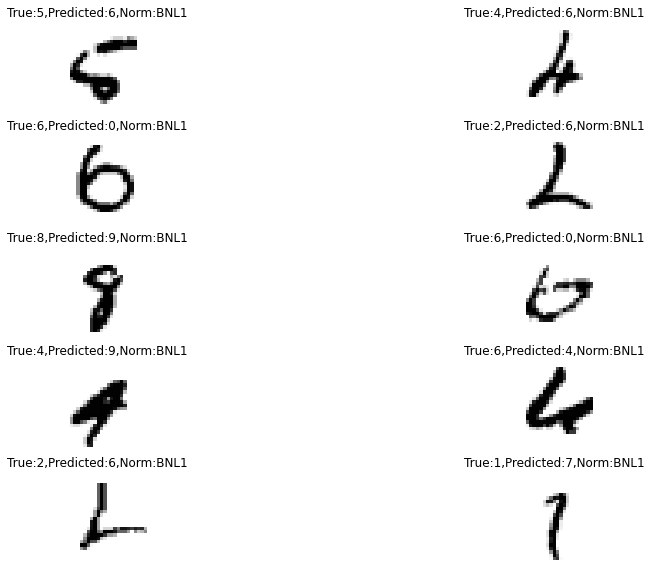

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

# load test data with batch size = 1 for predicting on CPU 
dataloader_args_ = dict(shuffle=False, batch_size=1)
test_ = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)
test_loader_ = torch.utils.data.DataLoader(test_, **dataloader_args_)

test_inf = datasets.MNIST('./data', train=False, download=True)

# keep model to CPU
device = torch.device("cpu")
modelBNL1 =  modelBNL1.to(device)
modelBNL1.eval()

mismatch_label_predicted = []
mismatch_images = []
mismatch_tgt = []
mismatch_index = []

index = 0
with torch.no_grad():
    for data_, target_ in test_loader_:
        output_ = modelBNL1(data_)
        pred = output_.argmax(dim=1, keepdim=True)

        if pred != target_ :
            image,label  = test_inf[index]
            mismatch_images.append(image)
            mismatch_label_predicted.append(pred.item())
            mismatch_tgt.append(target_)
            mismatch_index.append(index)
              
        if len(mismatch_index) == 10:
            break
            
        index += 1  
  

index = 0
figure = plt.figure()
plt.figure(figsize=(15,10))
num_of_images = 10
for index in range(1, num_of_images + 1):
    plt.subplot(5, 2, index)
    plt.axis('off')
    plt.gca().set_title('True:{0},Predicted:{1},Norm:BNL1 '.format(mismatch_tgt[index-1].item(), mismatch_label_predicted[index-1]))
    plt.imshow(mismatch_images[index-1], cmap='gray_r')
    
plt.savefig('BN10missmatch.jpg', bbox_inches='tight')
